# Chapter 4. Linear Regression
## text: Statistical Rethinking 

In [4]:
#import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import arviz as az

In [5]:
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## 4.1 Why normal distribution is normal?

### 4.1.1 Normal by addition

Any process that adds together random values from the same distribution converges to
a normal.

#### Code 4.1

<br><br>
<img style="float: left;" src="pic/04_01.png"  width="550">

<br><br>
<img style="float: left;" src="pic/04_02.png"  width="550">

<br><br>
<img style="float: left;" src="pic/04_03.png"  width="550">

<br><br>
<img style="float: left;" src="pic/04_04.png"  width="550">

We generate for each person a list of 16 random numbers
between −1 and 1.   
These are the individual steps.   
Then we add these steps together to get
the position after 16 steps.   
Then we need to replicate this procedure 1000 times.

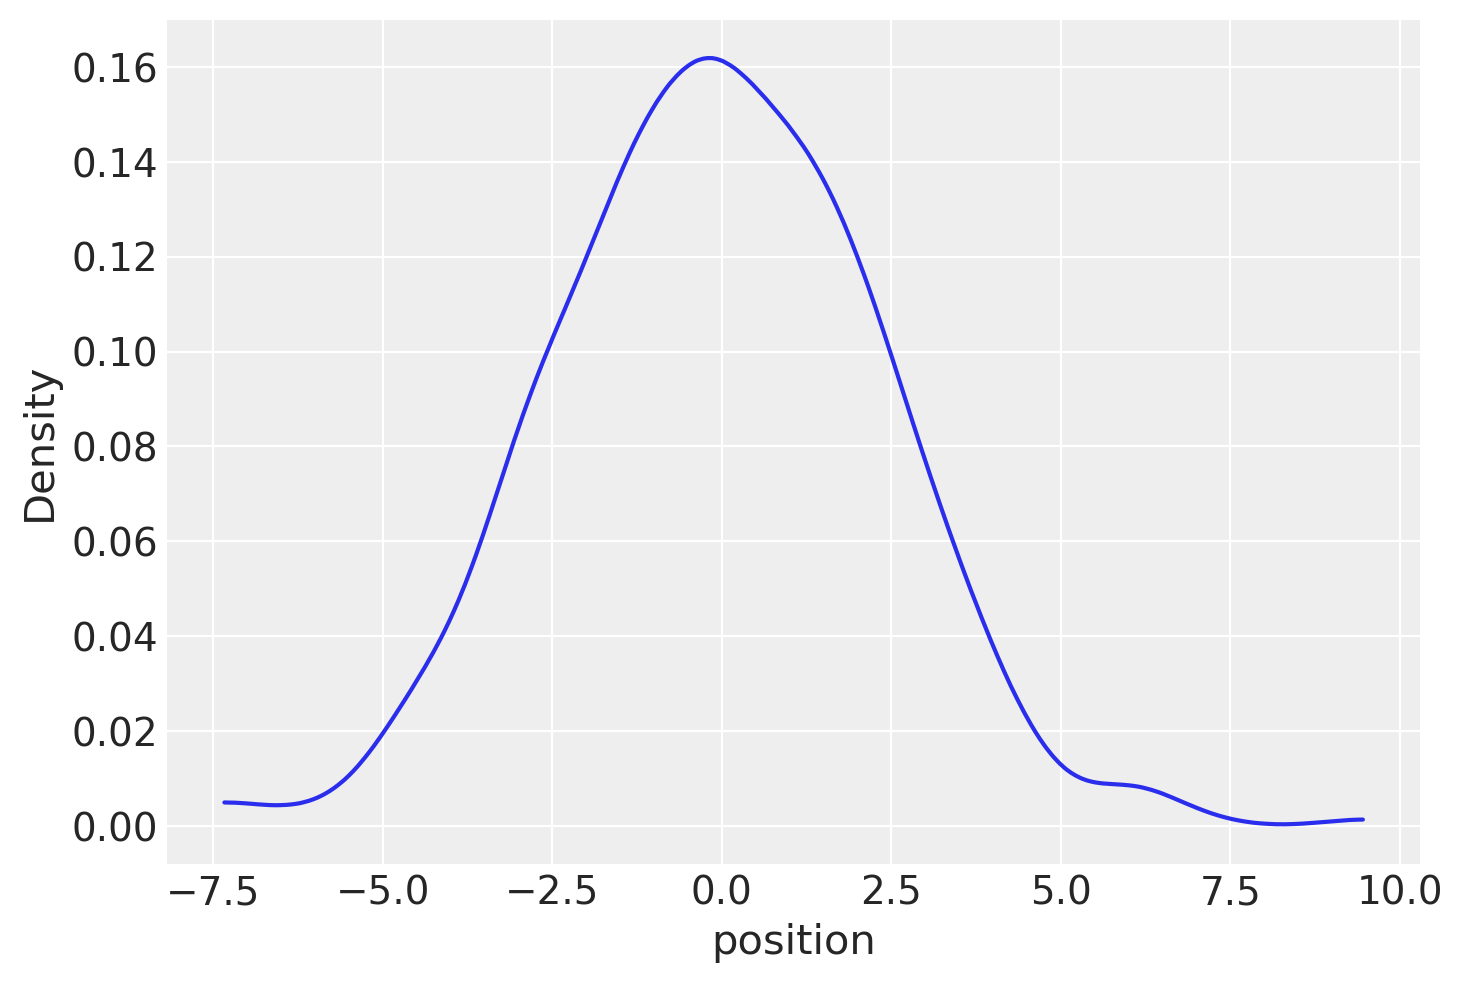

In [6]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos)
plt.xlabel('position')
plt.ylabel('Density');

### 4.1.2 Normal by multiplication

1.0 means no additional growth and 1.1 means a 10%
increase.   
The product of all 12 is computed and returned as output.   
Now what distribution
do you think these random products will take?   
Let’s generate 10,000 of them and see:

#### Code 4.2 and 4.3

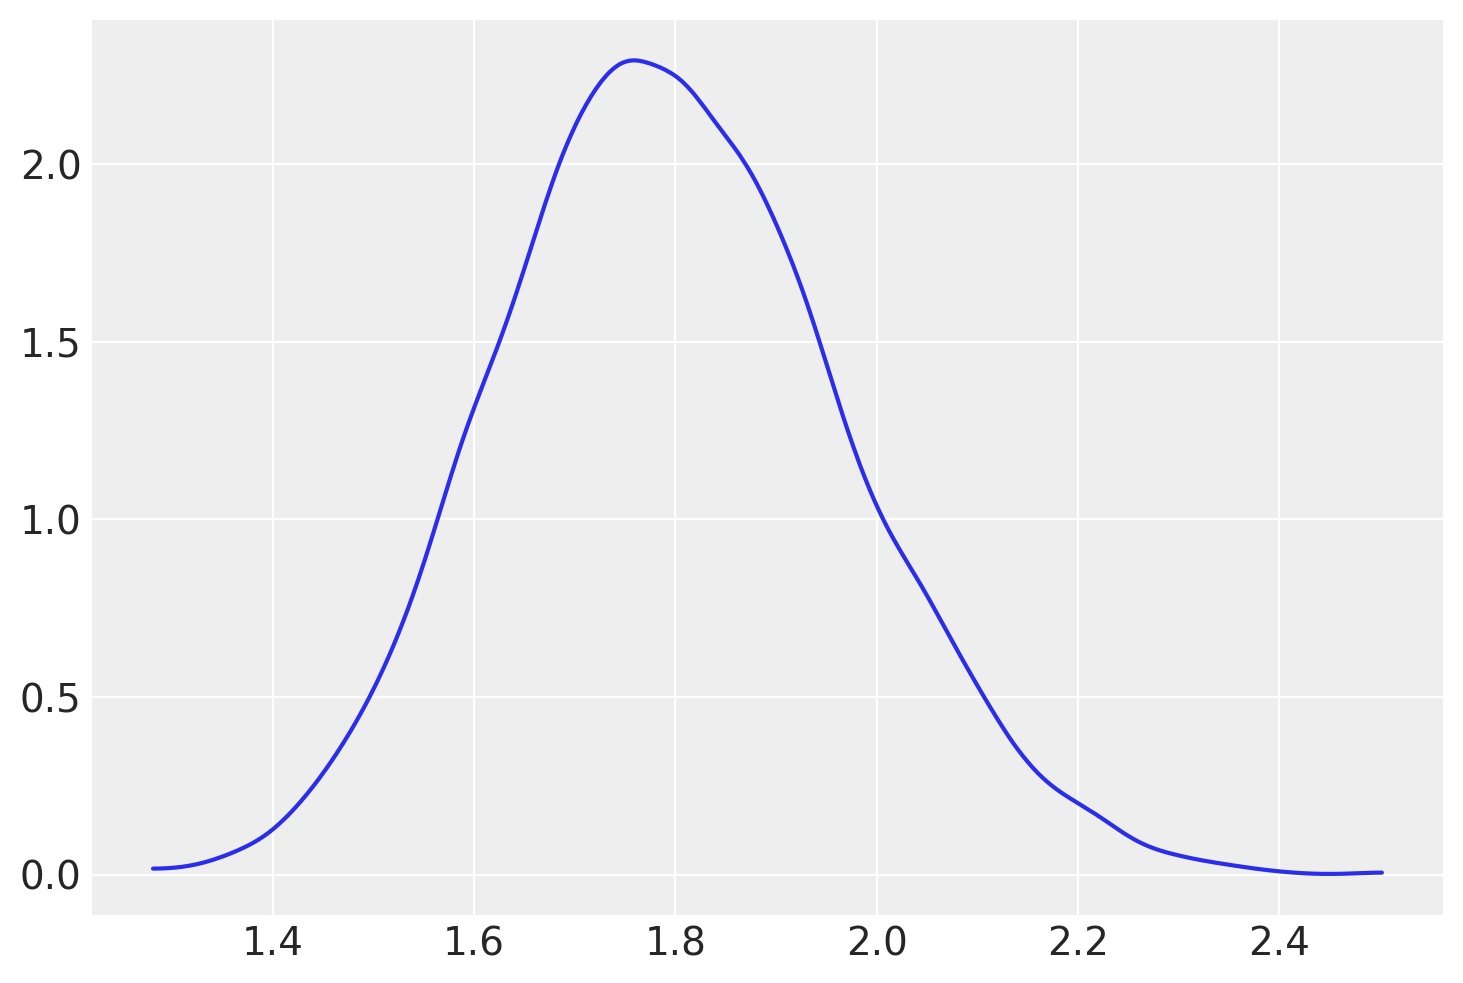

In [7]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
az.plot_kde(pos);

In [8]:
pos = np.random.uniform(1, 1.1, size=(12, 10000))

In [9]:
pos.prod?

Docstring:
a.prod(axis=None, dtype=None, out=None, keepdims=False, initial=1, where=True)

Return the product of the array elements over the given axis

Refer to `numpy.prod` for full documentation.

See Also
--------
numpy.prod : equivalent function
Type:      builtin_function_or_method


In [10]:
pos

array([[1.06508702, 1.00443958, 1.05327218, ..., 1.08700053, 1.06426156,
        1.00558524],
       [1.03628289, 1.07709951, 1.06671607, ..., 1.03466163, 1.01057828,
        1.06765522],
       [1.02305413, 1.06970191, 1.06314592, ..., 1.05437976, 1.09401095,
        1.0555582 ],
       ...,
       [1.01866484, 1.06932074, 1.09808977, ..., 1.02203846, 1.0708792 ,
        1.04559684],
       [1.04074717, 1.04939914, 1.00477641, ..., 1.02180193, 1.08473468,
        1.00452179],
       [1.01748782, 1.02845883, 1.01149352, ..., 1.07771186, 1.06567908,
        1.05717451]])

In [11]:
pos.shape

(12, 10000)

In [12]:
pos.prod(axis=0)

array([1.79226428, 1.77333285, 1.79596389, ..., 1.7928136 , 2.11839314,
       1.55691891])

In [14]:
pos.prod(axis=0).shape

(10000,)

We again get convergence towards a normal distribution, because the effect at each growth is quite small.   
Multiplying small numbers is approximately the same as addition.   
For
example, if there are two numbers increasing growth by 10% each, the product is:  
1.1 × 1.1 = 1.21  
We could also approximate this product by just adding the increases, and be off by only 0.01:  
1.1 × 1.1 = (1 + 0.1)(1 + 0.1) = 1 + 0.2 + 0.01 ≈ 1.2  
The smaller the effect of each locus, the better this additive approximation will be.   

#### Code 4.4

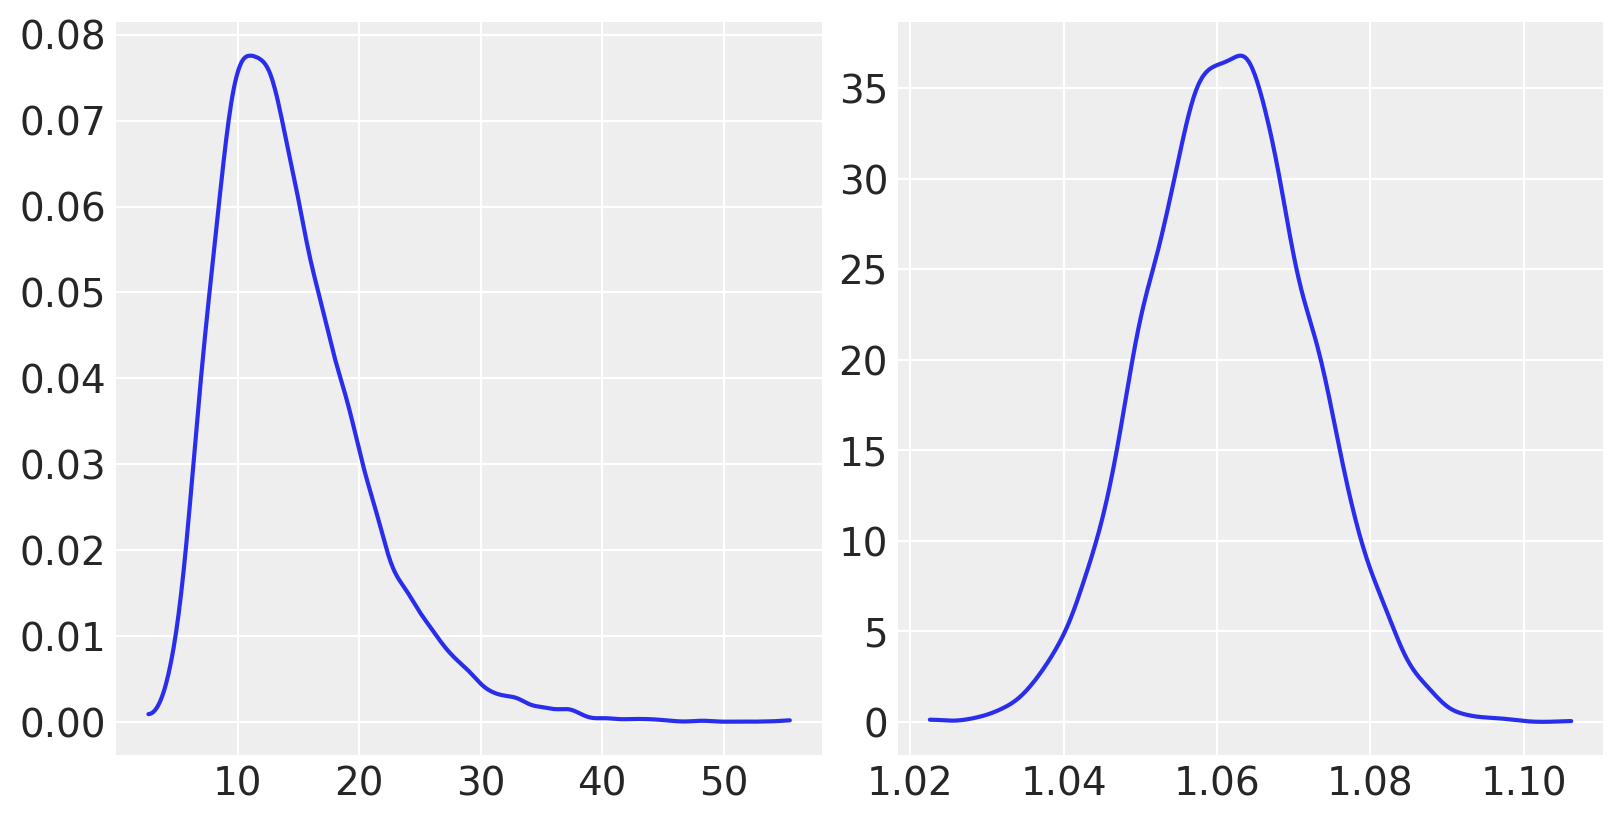

In [15]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

The interacting growth deviations, as long as they are sufficiently small, converge to a Gaussian distribution.   
In this way, the range of casual forces that tend towards Gaussian distributions extends well beyond purely additive interactions.

### 4.1.3 Normal by log-multiplication

But wait, there’s more.   
Large deviates that are multiplied together do not produce Gaussian distributions, but they do tend to produce Gaussian
distributions on the log scale. 

#### Code 4.5

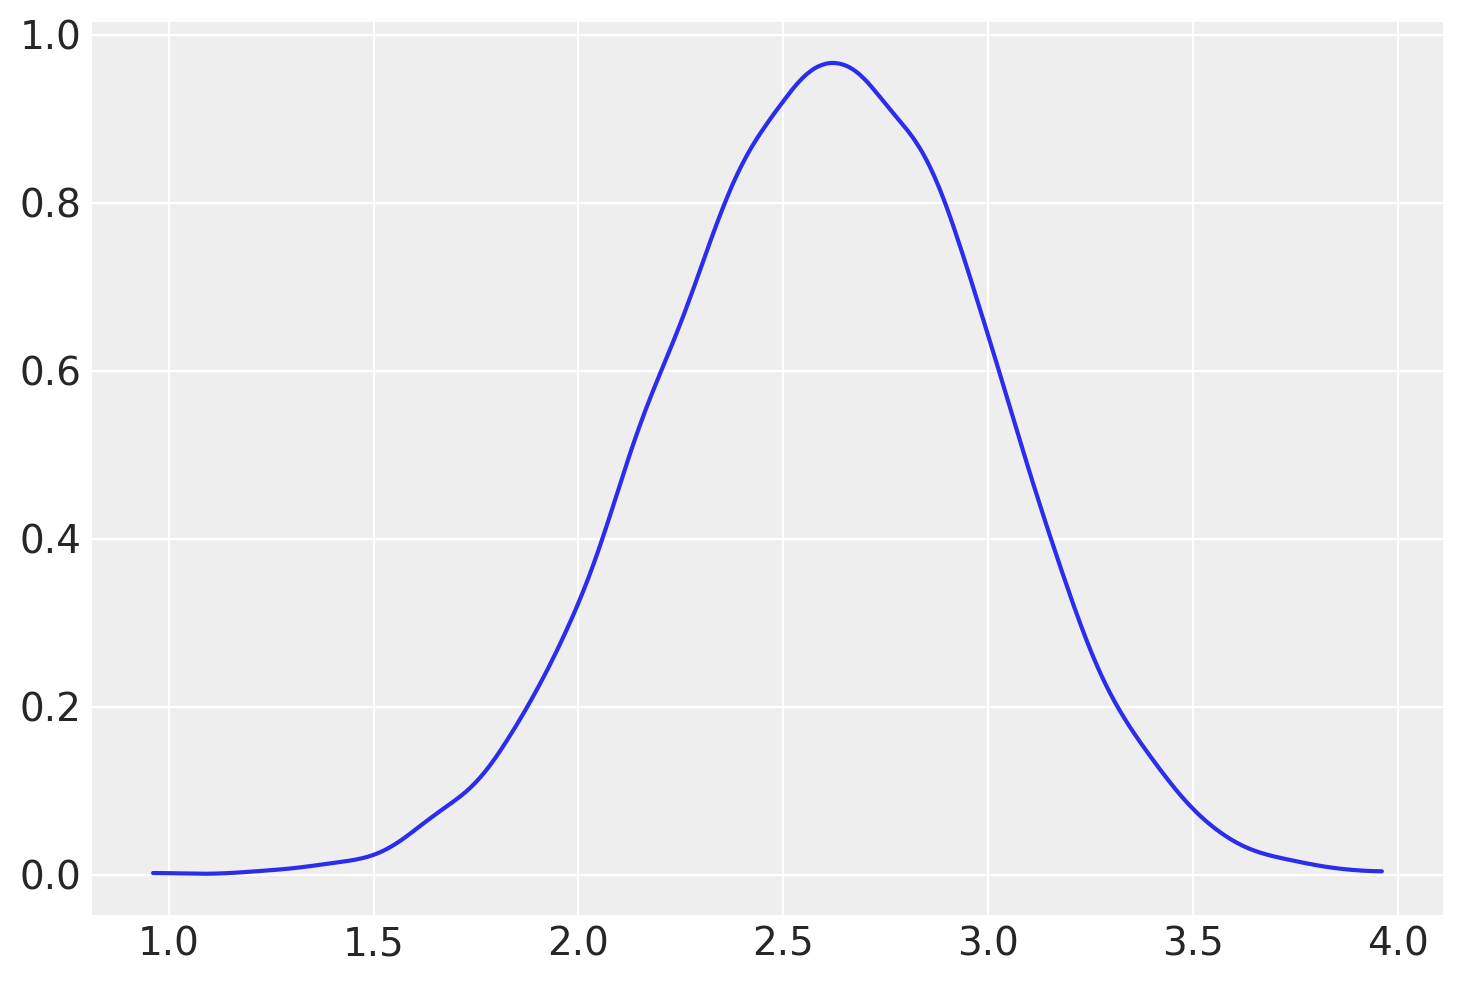

In [16]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

So even multiplicative interactions
of large deviations can produce Gaussian distributions, once we measure the outcomes on
the log scale. 

## 4.2. A language for describing models

**step 1:**  
First, we recognize a set of variables that we wish to understand.   
Some of these variables are observable.   
We call these data.   
Others are unobservable things like rates and averages.  
We call these parameters.

**step 2:**  
For each variable, we define it either in terms of the other variables or in terms of
a probability distribution.   
These definitions make it possible to learn about associations between variables.

**step 3:**  
The combination of variables and their probability distributions defines a joint generative model that can be used both to simulate hypothetical observations as well
as analyze real ones.

The biggest
difficulty usually lies in the subject matter—which variables matter and how does theory tell
us to connect them?—not in the mathematics.

<img style="float: left;" src="pic/04_05.png"  width="450">

where $W$ was the observed count of water,   
$N$ was the total number of tosses,   
and $p$ was the proportion of water on the globe. 

Read the above statement as:  
The count $W$ is distributed binomially with sample size $N$ and probability $p$.  
The prior for $p$ is assumed to be uniform between zero and one.  

Once we know the model in this way, we automatically know all of its assumptions.  
We know the binomial distribution assumes that each sample (globe toss) is independent of the
others, and so we also know that the model assumes that sample points are independent of
one another

For now, we'll focus on simple models like the above.   
In these models, the first line defines the likelihood function used in Bayes’ theorem.   
The other lines define priors.   
Both of the lines in this model are stochastic, as indicated by the $∼$ symbol.   
A stochastic relationship is just a mapping of a variable or parameter onto a distribution.   
It is stochastic because no single instance of the variable on the left is known with certainty.   
Instead, the mapping is probabilistic: Some values are more plausible than others, but very many different values are
plausible under any model.  
Later, we’ll have models with deterministic definitions in them as well.

Stochastic refers to a randomly determined process.  
Stochastic process and random process are considered interchangeable.

<img style="float: left;" src="pic/04_08.jpg"  width="450">

#### Code 4.6

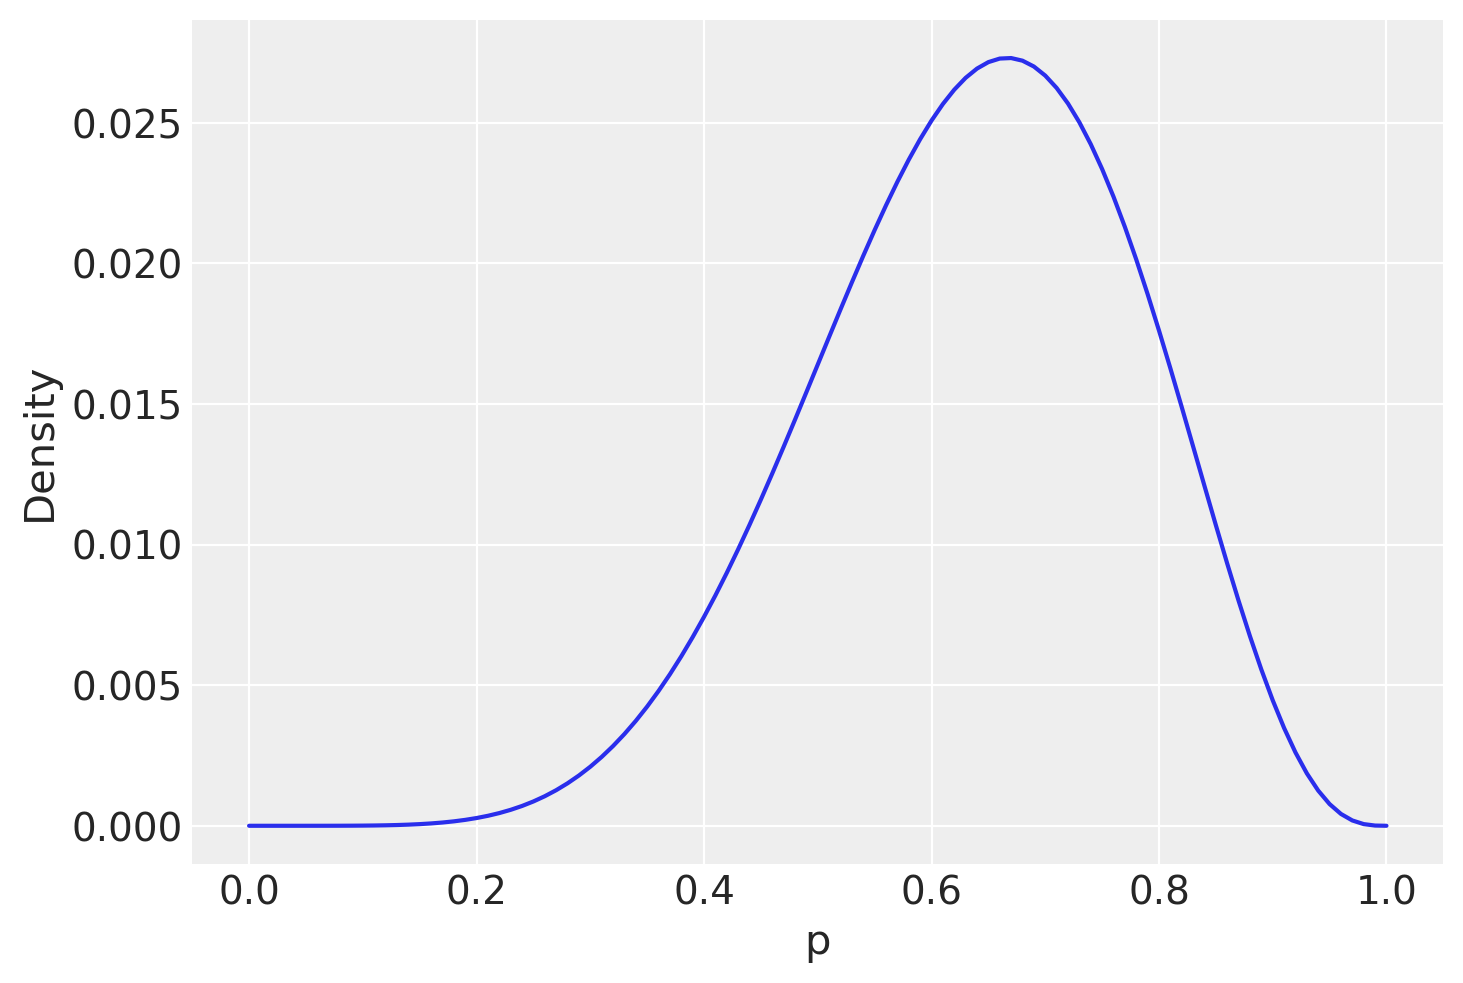

In [17]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 101)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

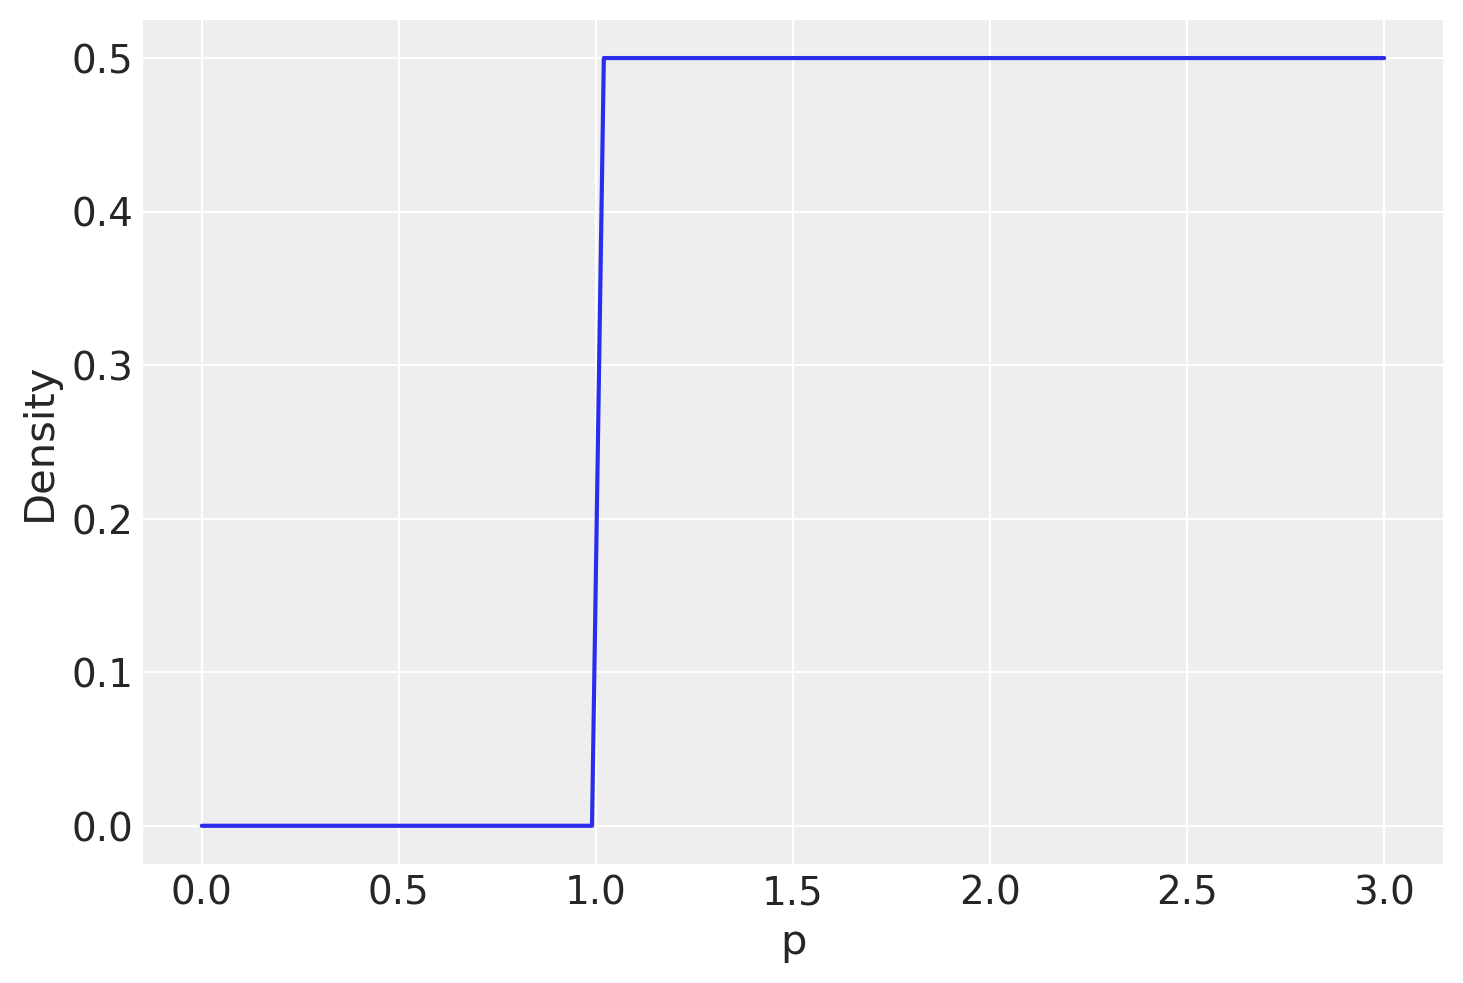

In [18]:
p_grid = np.linspace(0, 3, 101)
prior=stats.uniform.pdf(p_grid,1,2) # 구간 [1, 1+2] 에서 uniform distribution. 구간크기 2 * 밀도 0.5  = 1 
plt.plot(p_grid, prior)
plt.xlabel('p')
plt.ylabel('Density');

## 4.3. A Gaussian model of height

### 4.3.1. The data. 

The data contained in Howell1 are partial census data for the Dobe
area !Kung San, compiled from interviews conducted by Nancy Howell in the late 1960s.  
The !Kung San are the most famous foraging (수렵채집)
population of the 20th century..

#### Code 4.7 and 4.8

In [19]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

#### Code 4.9

In [20]:
d.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

#### Code 4.10

All we want for now are heights of adults in the sample. 

In [21]:
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [22]:
d2 = d[d.age >= 18]

In [23]:
d2

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

In [24]:
d2=d2.reset_index(drop=True)
d2

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
347  162.560  47.031821  27.0     0
348  142.875  34.246196  31.0     0
349  162.560  52.163080  31.0     1
350  156.210  54.062497  21.0     0
351  158.750  52.531624  68.0     1

[352 rows x 4 columns]

In [25]:
d2.describe()

height      weight         age        male
count  352.000000  352.000000  352.000000  352.000000
mean   154.597093   44.990486   41.138494    0.468750
std      7.742332    6.456708   15.967855    0.499733
min    136.525000   31.071052   18.000000    0.000000
25%    148.590000   40.256290   28.000000    0.000000
50%    154.305000   44.792210   39.000000    0.000000
75%    160.655000   49.292693   51.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

### 4.3.2. The model

<img style="float: left;" src="pic/04_06.png"  width="450">

<img style="float: left;" src="pic/04_07.png"  width="450">

<br><br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$hi ∼ Normal(µ, σ)$ &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            [likelihood]   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$µ ∼ Normal(178, 20)$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[µ prior]   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$σ ∼ Uniform(0, 50)$ 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
[σ prior]

Why 178 cm?   
Your author is 178 cm tall.   
And the range from 138 cm to 218 cm encompasses a huge range of plausible mean heights for human populations.   
So domain-specific
information has gone into this prior.   
Everyone knows something about human height and
can set a reasonable and vague prior of this kind.   
But in many regression problems, as you’ll
see later, using prior information is more subtle, because parameters don’t always have such
clear physical meaning.


Whatever the prior, it’s a very good idea to plot your priors, so you have a sense of the
assumption they build into the model.

#### Code 4.12

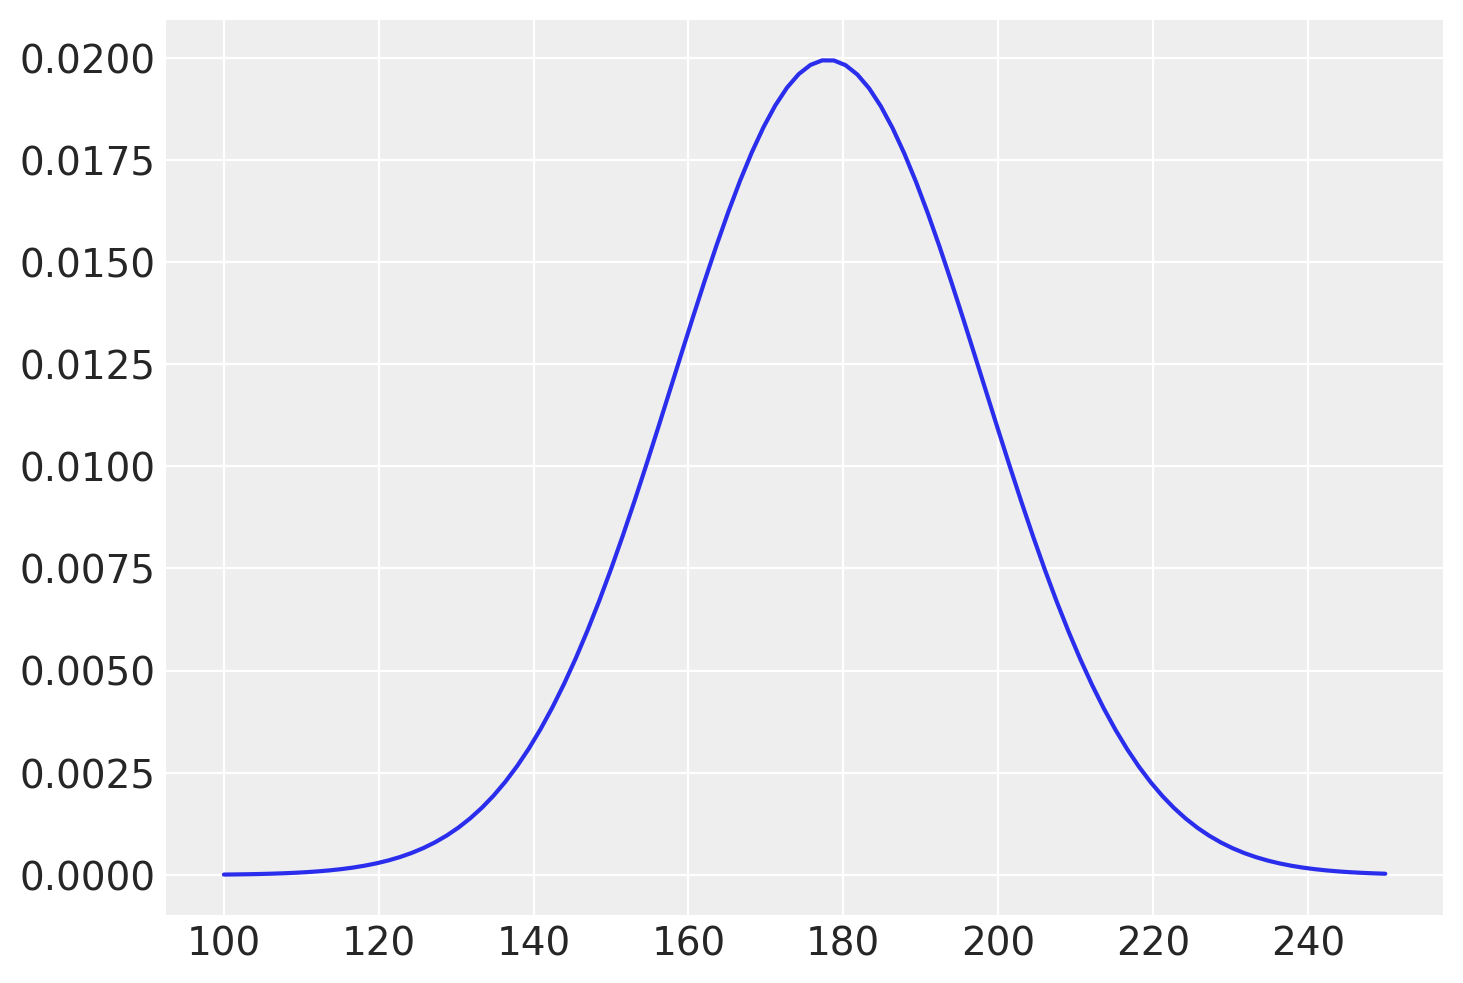

In [26]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20)); # mean=178, sigma=20 일때 p=x일 distribution

#### Code 4.13

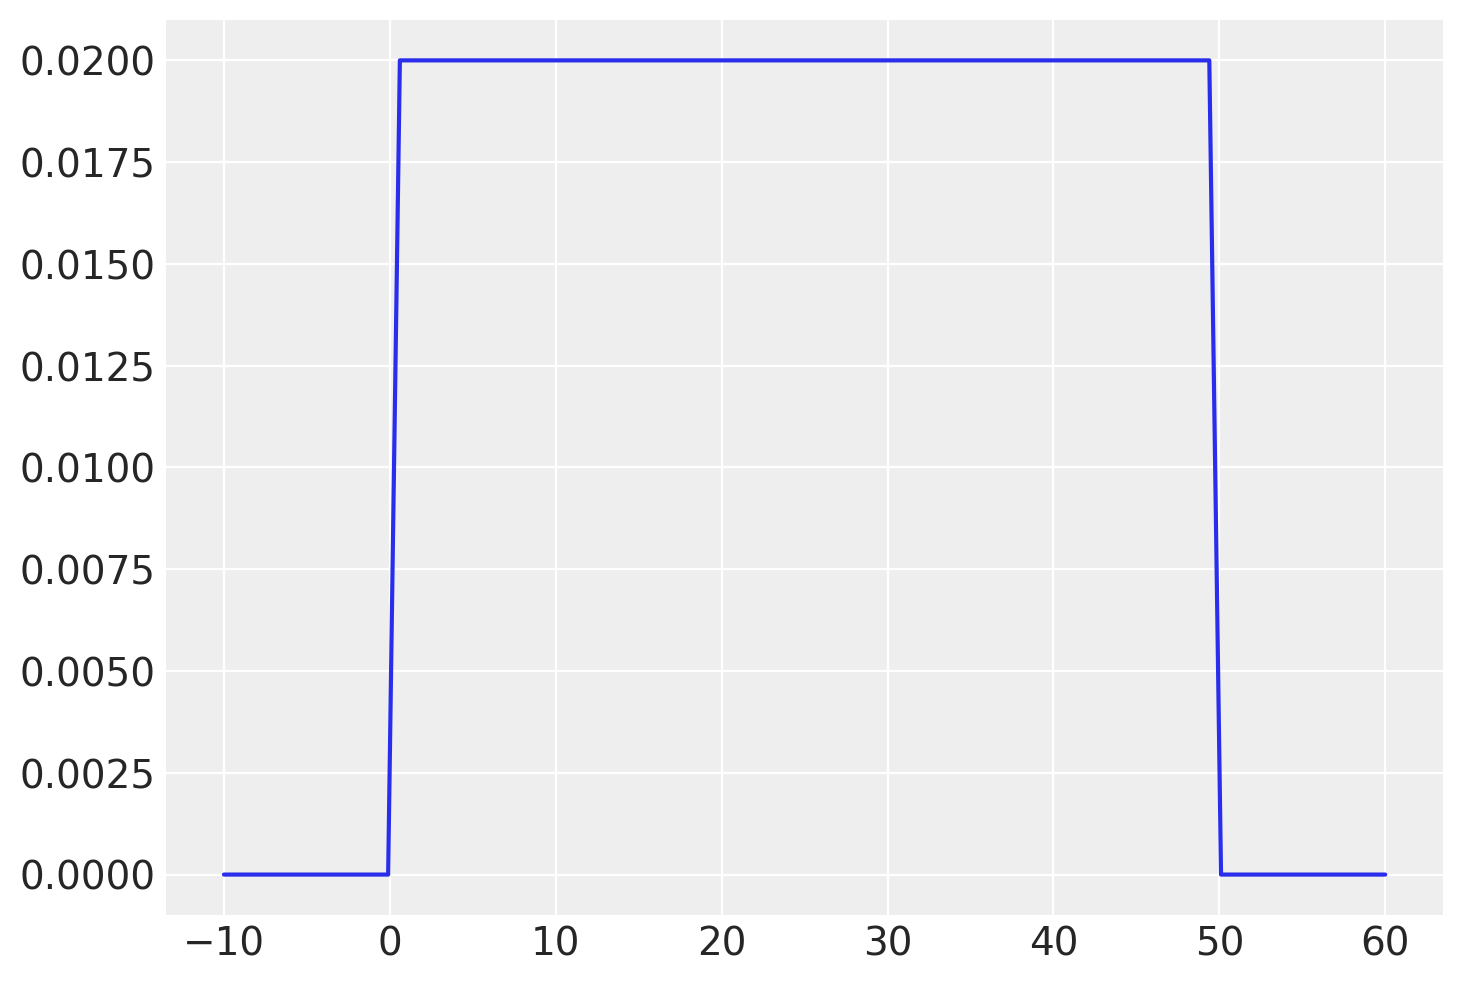

In [27]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

<img style="float: left;" src="pic/04_11.png"  width="450">

#### Code 4.14

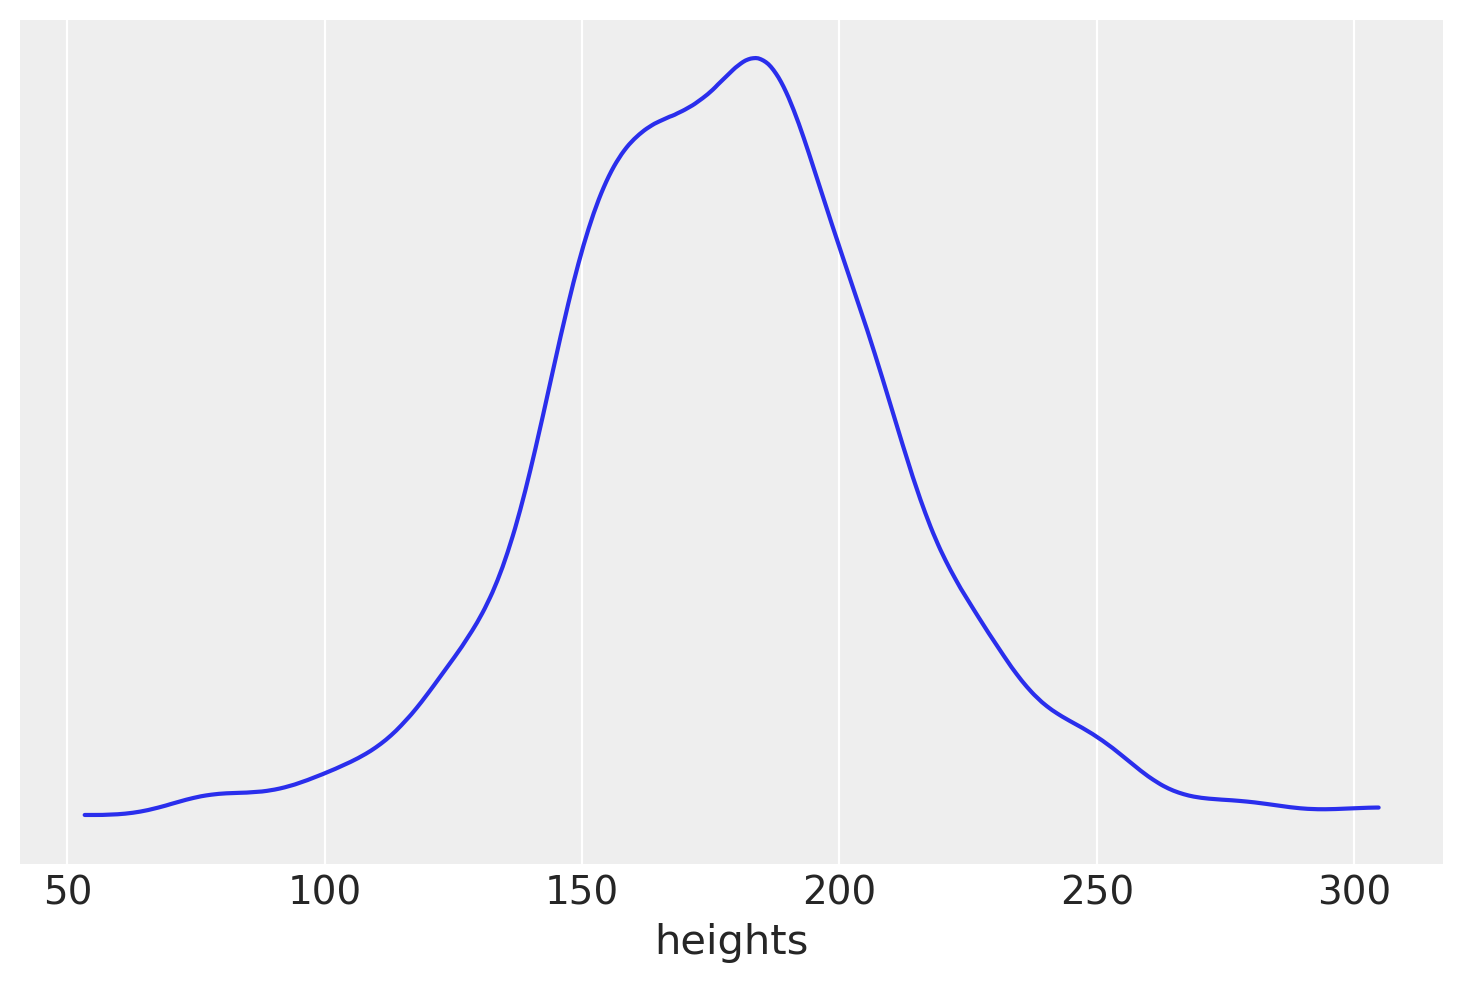

In [28]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

<br><br><br>

#### Code 4.15
만일 아래와 같이 바꾸면  
$µ ∼ Normal(178, 100)$

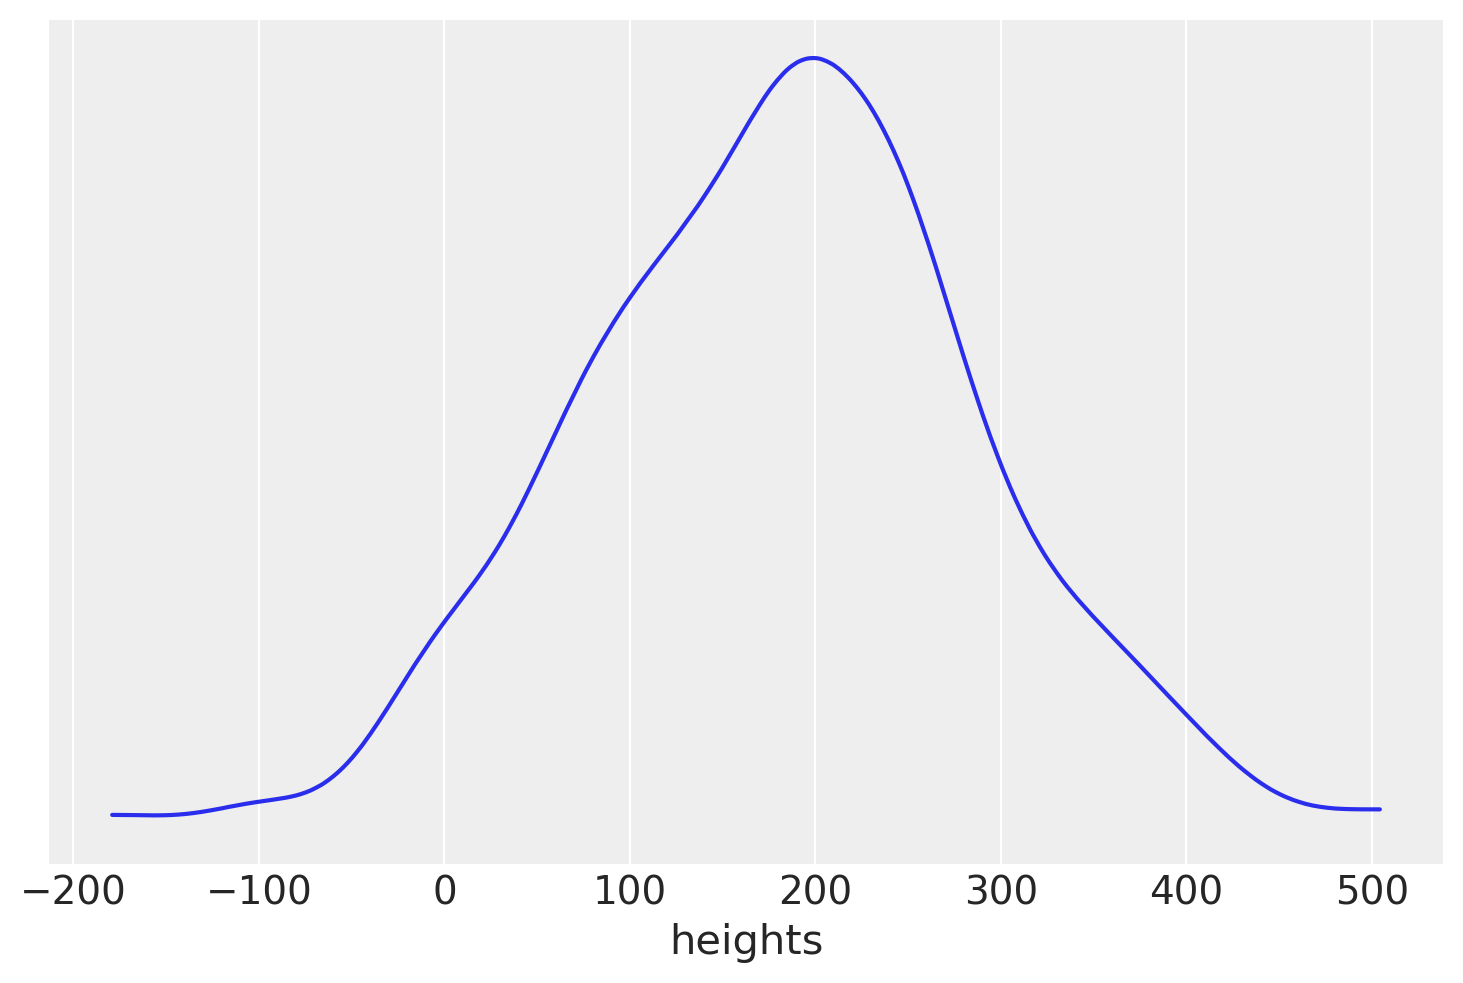

In [29]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel('heights')
plt.yticks([]);

<img style="float: left;" src="pic/04_12.png"  width="450">

<br><br><br><br>

### 4.3.3. Grid approximation of the posterior distribution.

This isn’t the approach I encourage in any other place, because it is laborious and computationally expensive.   
Indeed, it is usually so impractical as to be essentially impossible.   
But as always, it
is worth knowing what the target actually looks like, before you start accepting approximations of it. 

Data 는 130,140 이 관측 되었다.   
prior $µ$ 는 $µ ∼ Normal(178, 20)$ 로부터 두 값 140 및 150 이 sampling 되었으며,   
prior $\sigma$ 는 $\sigma ∼ Uniform(0, 50)$ 로부터 4,5,6 이 sampling 되었다 하자.     
$likelhood ∼ Normal(µ, σ)$  이다.
이 여섯 조합의 sampling points에 대한 posteria 를 구하자.

In [30]:
d2=d2[:2]
d2.height=[130,140]
d2

C:\Users\NN\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


height     weight   age  male
0     130  47.825606  63.0     1
1     140  36.485807  63.0     0

#### Code 4.16

post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

아래 코드는 계산이 복잡하여 추천하지 않는다.(책의 저자)

In [32]:
post = np.mgrid[140:160:10, 4:7:1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

In [33]:
post

array([[140,   4],
       [140,   5],
       [140,   6],
       [150,   4],
       [150,   5],
       [150,   6]])

In [34]:
len(post)

6

In [35]:
likelihood

[-7.735465788649126,
 -7.0567528912775455,
 -6.810284893754344,
 -20.235465788649126,
 -15.056752891277544,
 -12.3658404493099]

In [36]:
post[:,0][0]

140

In [37]:
post[:,1][0]

4

In [38]:
d2.height

0    130
1    140
Name: height, dtype: int64

In [39]:
stats.norm.logpdf(130, loc=post[:,0][0], scale=post[:,1][0])

-5.430232894324563

In [40]:
stats.norm.logpdf(140, loc=post[:,0][0], scale=post[:,1][0])

-2.305232894324563

In [41]:
stats.norm.logpdf(d2.height, loc=post[:,0][0], scale=post[:,1][0])

array([-5.43023289, -2.30523289])

In [42]:
sum(stats.norm.logpdf(d2.height, loc=post[:,0][0], scale=post[:,1][0]))

-7.735465788649126

In [43]:
[sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]


[-7.735465788649126,
 -7.0567528912775455,
 -6.810284893754344,
 -20.235465788649126,
 -15.056752891277544,
 -12.3658404493099]

In [44]:
[stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i]) for i in range(len(post))]


[array([-5.43023289, -2.30523289]),
 array([-4.52837645, -2.52837645]),
 array([-4.09958689, -2.710698  ]),
 array([-14.80523289,  -5.43023289]),
 array([-10.52837645,  -4.52837645]),
 array([-8.26625356, -4.09958689])]

In [45]:
post_prod

array([-17.3671596 , -16.6884467 , -16.44197871, -29.0421596 ,
       -23.8634467 , -21.17253426])

In [46]:
post_prob

array([3.96459695e-01, 7.81556373e-01, 1.00000000e+00, 3.37140531e-06,
       5.98270241e-04, 8.82156881e-03])

In [47]:
post_prob.sum()

2.187439278382788

The strategy is the same grid approximation strategy as before (page 39). But now there are two dimensions,
and so there is a geometric (literally) increase in bother. The algorithm is mercifully short, however, if not transparent. Think of the code as being six distinct commands. 

The first line of code just establishes the range of
µ and σ values, respectively, to calculate over, as well as how many points to calculate in-between. 
The code expands those chosen µ and σ values into a matrix of all of the combinations of µ and σ. This matrix
is stored in a data frame, post. 

In the second and third line of code, the log-likelihood at each combination of µ and σ is used. We have to be careful here to do everything on the log scale. Otherwise rounding error will quickly make all of the posterior probabilities zero. 

The second line passes the unique combination of µ and σ on each row of
post to a function that computes the log-likelihood of each observed height, and adds all of these log-likelihoods
together (sum). 

In the third line, we multiply the prior by the likelihood to get the product that is proportional
to the posterior density. The priors are also on the log scale, and so we add them to the log-likelihood, which is
equivalent to multiplying the raw densities by the likelihood. Finally, the obstacle for getting back on the probability scale is that rounding error is always a threat when moving from log-probability to probability. If you use
the obvious approach, like exp( post$prod ), you’ll get a vector full of zeros, which isn’t very helpful. This
is a result of the computer's rounding very small probabilities to zero. This is why you have to work with log-probability. 

The last code dodges this problem by scaling
all of the log-products by the maximum log-product. As a result, the values in post$prob are not all zero, but
they also aren’t exactly probabilities. Instead they are relative posterior probabilities. But that’s good enough for
what we wish to do with these values.

In [ ]:
likelihood2 = [(stats.norm.pdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])).prod() for i in range(len(post))]

post_prod2 = (likelihood2 * 
             stats.norm.pdf(post[:,0], loc=178, scale=20) * 
             stats.uniform.pdf(post[:,1], loc=0, scale=50))
post_prob2 = post_prod2 / max(post_prod2)

In [ ]:
[(stats.norm.pdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]


In [ ]:
likelihood2

In [ ]:
type(stats.norm.pdf(d2.height, loc=post[:,0][0], scale=post[:,1][0]))

In [ ]:
post_prod2

In [ ]:
post_prob2

위 두가지 방법의 계산결과 post_prob 와 post_prob2는 동일하다.     
그러나, post_prod 와 post_prod2는 그렇지 않다.  
prod_post2는 매우 큰 값을 갖거나, 0에 근접하는 매우 작은 값을 가질 수 있으며, 이는 round-off 에러를 발생시킬 가능성이 크다는 의미이다.  

따라서, PyMC3에서는 첫번째 방법인, prior, likelihood, posteria 에서 log를 취한다. 즉, logpdf, log-likelihood 를 사용한다.

원래 예제 4.16

In [ ]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

In [ ]:
post_prob

In [ ]:
sum(post_prob ==0)

In [ ]:
likelihood2 = [(stats.norm.pdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])).prod() for i in range(len(post))]

post_prod2 = (likelihood2 * 
             stats.norm.pdf(post[:,0], loc=178, scale=20) * 
             stats.uniform.pdf(post[:,1], loc=0, scale=50))
post_prob2 = post_prod2 / max(post_prod2)

In [ ]:
post_prob2

In [ ]:
sum(post_prob2 ==0)

roud-off 에러로 0 이되는 값이 얼마나 많아지는지에 관한 예: 4.16에서 그리드 위치만 변경

In [ ]:
post = np.mgrid[10:30:0.1, 4:10:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

In [ ]:
likelihood2 = [(stats.norm.pdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])).prod() for i in range(len(post))]

post_prod2 = (likelihood2 * 
             stats.norm.pdf(post[:,0], loc=178, scale=20) * 
             stats.uniform.pdf(post[:,1], loc=0, scale=50))
post_prob2 = post_prod2 / max(post_prod2)

In [ ]:
post_prob

In [ ]:
sum(post_prob ==0)

In [ ]:
post_prob2

In [ ]:
sum(post_prob2 ==0)

#### Code 4.17 

You can inspect this posterior distribution, now residing in post$prob, using a variety of
plotting commands. You can get a simple contour plot.

In [ ]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.head()

In [ ]:
d = d[d.age >= 18]

In [ ]:
d

In [ ]:
d=d.reset_index(drop=True)
d

In [ ]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

In [ ]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code  4.18 (생략)

<br><br><br>

### 4.3.4. Sampling from the posterior.

#### Code 4.19 and 4.20

In [ ]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu')
plt.ylabel('sample_sigma');

In [ ]:
sample_rows 

In [ ]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))

In [ ]:
post.shape

In [ ]:
np.arange(len(post))

In [ ]:
post_prob/post_prob.sum()

In [ ]:
p=(post_prob/post_prob.sum())

In [ ]:
p.shape

0~9999는 그리드 점의 갯수를 나타내며, 각 점은 µ 1개 와 σ 1개의 쌍을 나타낸다.
code 4.19의 첫 줄은 0~9999 까지 각각의 확률이 p 일때, size=10000개를 랜덤하게 선택
즉, posterior probability로 부터 probability density(p로 나타냄)를 고려하여 랜덤하게 10000개 샘플 채취

두번째 및 세번째 줄은, 샘플로부터 µ 값과 σ값을 분리

네번째 줄은 나온 횟수에 따라 색깔을 조정하여 plot

#### Code 4.21

In [ ]:
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(sample_mu, ax=ax[0])
ax[0].set_xlabel('sample_mu')
ax[0].set_yticks([])
az.plot_kde(sample_sigma, ax=ax[1])
ax[1].set_xlabel('sample_sigma')
ax[1].set_yticks([]);

#### Code 4.22: highest posterior density intervals

In [ ]:
az.hpd(sample_mu), az.hpd(sample_sigma)

#### Code 4.23 and  4.24

For a Gaussian likelihood and a Gaussian prior on $\mu$, the posterior distribution is always Gaussian
as well, regardless of sample size.   
It is the standard deviation $\sigma$ that causes problems.  
The deep reasons for the posterior of $\sigma$ tending to have a long right-hand tail are complex.  
Let’s quickly analyze only 20 of the heights from the height data.

In [ ]:
d3 = np.random.choice(d2.height, 20)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post2[:,0][i], scale=post2[:,1][i])) for i in range(len(post2))]

post_prod2 = (likelihood2 + 
              stats.norm.logpdf(post2[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post2[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = np.random.choice(np.arange(len(post2)), size=10000, replace=True, 
                               p=(post_prob2/post_prob2.sum()))
sample_mu2 = post2[:,0][sample_rows2]
sample_sigma2 = post2[:,1][sample_rows2]

In [ ]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2')
plt.ylabel('sample_sigma2')
plt.grid(False)

#### Code 4.25

In [ ]:
az.plot_kde(sample_sigma2)
plt.xlabel('sample_sigma2')
plt.yticks([]);

This code will also show a normal approximation with the same mean and variance. Now you can
see that the posterior for $\sigma$  is not Gaussian, but rather has a long tail of uncertainty towards higher
values.

<br><br><br>

## AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

### 4.3.5  Pymc3 이용

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10

In [ ]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d2 = d[d.age >= 18]

#### Code 4.27

In [ ]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)

#### Code 4.28

We could use a quadratic approximation like McElreath does in his book and we did in code 2.6. But Using PyMC3 is really simple to just sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC3 comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC3 choose the sampler for us. PyMC3 also tries to provide a reasonable starting point for the simulation. By default PyMC3 uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which start with a identity mass matrix and then adapt a diagonal based on the variance of the tuning samples. 

You can read more details of PyMC3 [here](http://pymc-devs.github.io/pymc3/notebooks/getting_started.html)

In [ ]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

In [ ]:
az.plot_trace(trace_4_1); # this function let you check the samples values

#### Code 4.29

Notice that compared to the table in the book we have an extra column, "mc_error". Since we are sampling from the posterior, there is an error introducing by the sampling process. This error can be reduced by taking more samples.

In [ ]:
az.summary(trace_4_1, credible_interval=.89).round(2)

#### Code 4.30

testval 은 initial value를 가르킨다.

In [ ]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)

In [ ]:
az.plot_trace(trace_4_1); 
az.summary(trace_4_1, credible_interval=.11).round(2)

#### Code 4.31

mu = pm.Normal('mu', mu=178, sd=0.1)의 sd 값 변경

In [ ]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)

In [ ]:
az.plot_trace(trace_4_2); 
az.summary(trace_4_2, credible_interval=.11).round(2)

In [ ]:
az.summary(trace_4_2, credible_interval=.89).round(2)

#### Code 4.32

For some computations could be nice to have the trace turned into a DataFrame, this can be done using the `trace_to_dataframe` function

In [ ]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

#### Code 4.33

In [ ]:
np.diag(trace_df.cov())

In [ ]:
trace_df.corr() #correlation

#### Code 4.34

We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can do something like

In [ ]:
trace_df.head()

Or directly from the trace (we are getting the first ten samples of _sigma_)

In [ ]:
trace_4_1['sigma'][:10]

#### Code 4.35

In our case, this is the same we did in the code 4.27

In [ ]:
az.summary(trace_4_1, credible_interval=.89).round(2)

#### Code 4.36: multivariate sampling

In [ ]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

#### Code extra

Instead of sampling from a normal and then exponentiating to ensure sigma is positive, we can use the lognormal distribution for the same result. The Lognormal distribution is parametrized in terms of $\tau$ (tau) the precision and not the standard deviation, where: 

$$tau=\frac{1}{\sigma^2}$$

The normal distribution can also be parametrized in terms of the precision (tau). Given that the conversion between both parametrization is done right, which one to use is only a matter of convenience. 

그러나, m4-1에서 sigma는 Uniform 이었다.    
어쨋든

In [ ]:
with pm.Model() as m4_1_logsigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Lognormal('sigma', mu=2, tau=0.01)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_1_logsigma = pm.sample(1000, tune=1000)

In [ ]:
az.plot_trace(trace_4_1_logsigma);

<br><br><br>

## 4.4  Adding a Predictor

<br><br>
<img style="float: left;" src="pic/04_13.png"  width="400">

#### Code 4.37

In [ ]:
plt.plot(d2.height, d2.weight, '.');

<br><br>
<img style="float: left;" src="pic/04_14.png"  width="400">

<br><br>
<img style="float: left;" src="pic/04_15.png"  width="400">

#### Code 4.38 and 4.39

Notice that the variable mu is defined as alpha + beta * d2.weight in a single line. If we want the trace to contain mu we can write as a deterministic varible. The computating will be exactly the same. The only difference is that mu will be accessible in the trace.

In [ ]:
with pm.Model() as m4_3:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight
    #mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

In [ ]:
az.plot_trace(trace_4_3);

Another alternative is to write mu inside the likelihood and not as a separate line.

    height = pm.Normal('height', mu=alpha + beta * d2.weight, sd=sigma, observed=d2.height)
    
Using PyMC3 there is not too much reason to do this. I personally think that defining mu in a separate line improves readability.

#### Code 4.40

In [ ]:
az.summary(trace_4_3, credible_interval=.11).round(2)

#### Code 4.41

In [ ]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

#### Code 4.42

In [ ]:
d2 = d2.assign(weight_c=pd.Series(d2.weight - d2.weight.mean()))

#### Code 4.43

In [ ]:
with pm.Model() as m4_4:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = alpha + beta * d2.weight_c
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

#### Code 4.44

In [ ]:
az.summary(trace_4_4, credible_interval=.11).round(2)

#### Code 4.46

Instead of using the MAP, we are going to use the mean of the posterior 

In [ ]:
plt.plot(d2.weight, d2.height, '.')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code  4.47

In [ ]:
pm.trace_to_dataframe(trace_4_4)[:5]

#### Code 4.48

In [ ]:
N = [10, 50, 150, 352][0]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

In [ ]:
N

In [ ]:
chain_N = trace_N[100:]
az.plot_trace(chain_N, var_names='~mu');

<br><br>
<img style="float: left;" src="pic/04_16.png"  width="400">

#### Code 4.49

In [ ]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * d2.weight[:N], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [ ]:
N

In [ ]:
idx

In [ ]:
len(chain_N)

위 그림은 N=10 개의 데이터를 사용하여, chain_N=900 개의 posteria points로 부터 20개를 랜덤하게 택하여, 회귀직선을 그린 그림이다.

Alternative we can directly use the deterministic mu variable

In [ ]:
plt.plot(d2.weight[:N], d2.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

<br><br><br>

### 4.4.3.4  Plotting

#### Code 4.50 and 4.51

데이터를 50개 사용해보자.

In [ ]:
N = [10, 50, 150, 352][1]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=d2.height[:N])
    trace_N = pm.sample(1000, tune=1000)

In [ ]:
chain_N = trace_N[100:]

In [ ]:
N

In [ ]:
plt.plot(d2.weight[:50], d2.height[:50], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(d2.weight[:N], chain_N['mu'][idx], 'C1-', alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

In [ ]:
N

In [ ]:
df_4_4=pm.trace_to_dataframe(trace_4_4)

In [ ]:
df_4_4.shape

In [ ]:
df_4_4=df_4_4[::5]

In [ ]:
df_4_4.shape

In [ ]:
mu_at_50 = df_4_4["alpha"] +df_4_4["beta"]*(50-d2.weight.mean())

In [ ]:
az.plot_kde(mu_at_50)
plt.xlabel('heights')
plt.yticks([]);

#### Code 4.52

In [ ]:
az.hpd(mu_at_50, credible_interval=.89)

#### Code 4.53

Using PyMC3, we do not need to compute anything else. By defining a deterministic variable mu in the model, we add that variable to the trace. Thus we get a matrix with row samples from the posterior and columns values of weights. We can access this matrix directly from the trace or turn it into a DataFrame, it all depends on what we need.

In [ ]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

In [ ]:
pm.summary(trace_N)

In [ ]:
df_trace_N = pm.trace_to_dataframe(chain_N)
df_trace_N.head()

#### Code 4.54 and 4.58

We are doing _manually_, in the book is done using the ```link``` function. In the book on code 4.58 the following operations are performed _manually_.

In [ ]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

#### Code 4.55

In [ ]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

In [ ]:
mu_pred.shape

46은  np.arange(25, 71)로부터 왔으며, weight 25 Kg 부터 70 Kg 까지를 가르킨다.

In [ ]:
chain_N

따라서 4 * 900 = 3600 개의 시뮬레이션 결과 값

chain_N_thinned = chain_N[::10] 이므로, chain_N_thinned 는 360 개

#### Code 4.56

In [ ]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T, credible_interval=.89)

In [ ]:
mu_pred.shape

In [ ]:
mu_mean.shape

In [ ]:
mu_hpd.shape

In [ ]:
mu_hpd

#### Code 4.57

In [ ]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

##### Code 4.59

Now we are going to use ```pm.sample_posterior_predictive``` from PyCM3. This function give us posterior predictive samples, that is for each value of the input variable we get the a sample (from the posterior) of the output variable. Thus in the following example the shape of height_pred['height_hat'].shape is (200, 50)

In [ ]:
height_pred = pm.sample_posterior_predictive(chain_N, 200, m_N)

In [ ]:
height_pred

In [ ]:
height_pred.keys()

In [ ]:
height_pred['height_hat'].shape

#### Code 4.60

In [ ]:
height_pred_hpd = az.hpd(height_pred['height_hat'])

Let’s plot everything we’ve built up:   
(1) the average line,   
(2) the shaded region of 89% plausible µ, and   
(3) the boundaries of the simulated heights the model expects.

#### Code 4.61

In [ ]:
plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')                     # (1) the average line
az.plot_hpd(weight_seq, mu_pred.T)                     # (2) the shaded region of 89% plausible µ, and
az.plot_hpd(d2.weight[:N], height_pred['height_hat'])  # (3) the boundaries of the simulated heights the model expects.
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values. Because we are getting samples at the input values the jaggedness of this plot is larger than the one in the book.

(생략)
#### Code 4.63

Now we are going to generate heights from the posterior _manually_, instead of restricting to the input values we are going to pass an array of equally spaced weights values ```weight_seg```.

weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pr = chain_N['alpha'][i] + chain_N['beta'][i] * weight_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

plt.scatter(d2.weight[:N], d2.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(weight_seq, np.array(post_samples))
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(d2.weight.min(), d2.weight.max());

## 4.5.1. Polynomial regression

<br><br>
<img style="float: left;" src="pic/04_17.png"  width="450">

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [ ]:
d.head()

The first thing to do is to standardize the predictor variable.   
We’ve done this is previous examples.   
But this is especially helpful for working with polynomial models.   
When predictor variables have very large values in them, there are sometimes numerical glitches(예기치 않은 고장, malfunction).  
Even well-known statistical software can suffer from these glitches, leading to mistaken estimates.  
These problems are very common for polynomial regression, because the square or cube of a large number can be truly
massive.   
Standardizing largely resolves this issue.   
It should be your default behavior.

<br><br>
<img style="float: left;" src="pic/04_18.png"  width="400">

#### Code 4.65

In [ ]:
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
d["weight_std2"] = d.weight_std**2

#### Code 4.66

In [ ]:
with pm.Model() as m_4_5:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_std + beta[1] * d.weight_std2)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

In [ ]:
varnames = ['~mu']
az.plot_trace(trace_4_5, varnames);

#### Code 4.67

In [ ]:
az.summary(trace_4_5, varnames, credible_interval=.89).round(2)

#### Code 4.68

In [ ]:
mu_pred = trace_4_5['mu']
height_pred = pm.sample_posterior_predictive(trace_4_5, 200, m_4_5)

#### Code 4.69

In [ ]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_std, height_pred['height'], credible_interval=.89)

## cubic regression

<br><br>
<img style="float: left;" src="pic/04_19.png"  width="500">

#### Code 4.70

We will stack the weights to get a 2D array, these simplifies wrriting a model. Now we can compute the dot product between beta and the 2D-array

In [ ]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [ ]:
with pm.Model() as m_4_6:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)

In [ ]:
pm.traceplot(trace_4_6, varnames);

In [ ]:
mu_pred = trace_4_6['mu']
height_pred = pm.sample_posterior_predictive(trace_4_6, 200, m_4_6)

#### Code 4.71 and 4.72

In [ ]:
plt.scatter(d.weight_std, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_std, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_std, height_pred['height'], credible_interval=.89)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("""This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nArviZ {}\nNumPy {}\nSciPy {}\nMatplotlib {}\n""".format(sys.version[:5], IPython.__version__, pm.__version__, az.__version__, np.__version__, scipy.__version__, matplotlib.__version__))